📊 EDA Companies in Spain 2020-2024
Autor: Antonio Romero
# Purpose: Exploratory data analysis (EDA)
# Files: Datos empresas.xlsx | Empresas por condición jurídica.xlsx | PIB por actividad económica.xls
# Datasource: www.INE.es

BLOCK 1: Loading libraries and files

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Input file paths (parametrize as needed)
FILE_EMPRESAS = 'C:/Users/anto-/OneDrive/Desktop/PracticasMaster/Ejercicios/Proyecto final/Datos empresas.xlsx'
FILE_JURIDICO = 'C:/Users/anto-/OneDrive/Desktop/PracticasMaster/Ejercicios/Proyecto final/Empresas por condición jurídica.xlsx'
FILE_PIB = 'C:/Users/anto-/OneDrive/Desktop/PracticasMaster/Ejercicios/Proyecto final/PIB por actividad económica.xlsx'
FILE_BRIDGE = 'C:/Users/anto-/OneDrive/Desktop/PracticasMaster/Ejercicios/Proyecto final/actividad principal y ramas de actividad.xlsx'

# Key columns to normalize and merge
ACTIVIDAD_EMPRESAS = 'Actividad principal'
ACTIVIDAD_PIB = 'Actividad Económica'

# Load data from Excel files
df_empresas = pd.read_excel(FILE_EMPRESAS)
df_juridico = pd.read_excel(FILE_JURIDICO)
df_pib = pd.read_excel(FILE_PIB)
df_bridge = pd.read_excel(FILE_BRIDGE)

print(f"Data loaded: {df_empresas.shape[0]} empresas, {df_pib.shape[0]} PIB records.")

Data loaded: 434199 empresas, 2700 PIB records.


BLOCK 2: DATA CLEANING

In [3]:
# Normalize activity fields for merging

df_empresas[ACTIVIDAD_EMPRESAS] = df_empresas[ACTIVIDAD_EMPRESAS].str.strip().str.upper()
df_pib['Ramas de actividad'] = df_pib['Ramas de actividad'].str.strip().str.upper()
ACTIVIDAD_PIB = 'Ramas de actividad'
df_empresas['CCAA'] = df_empresas['CCAA'].astype(str).str.strip().str.upper()

# Load bridge table for activity normalization
df_bridge = pd.read_excel(FILE_BRIDGE)
df_bridge.columns = df_bridge.columns.str.strip()
print("Activity fields normalized for merge.")

group_cols = [ACTIVIDAD_EMPRESAS, 'Estrato de asalariados']

df_profile = df_empresas.groupby(group_cols).size().reset_index(name='Nº Empresas')
df_ccaa = df_empresas.groupby('CCAA').size().reset_index(name='Nº Empresas')

print(f"Profile segmented: {df_profile.shape[0]} grouped rows.")
print("Bridge columns:", df_bridge.columns.tolist())

Activity fields normalized for merge.
Profile segmented: 4342 grouped rows.
Bridge columns: ['Rama de Actividad', 'Actividad Principal']


BLOCK 3: MERGE WITH PIB DATA

In [9]:
# Rename PIB column for clarity
df_pib = df_pib.rename(columns={'Total': 'PIB (€)'})

# Merge with juridical condition
df_merged = pd.merge(df_profile,
                     df_pib,
                     left_on=ACTIVIDAD_EMPRESAS,
                     right_on=ACTIVIDAD_PIB,
                     how='left')

df_merged.drop(ACTIVIDAD_PIB, axis=1, inplace=True)

# Fallback: fill PIB missing with 0
df_merged['PIB (€)'] = df_merged['PIB (€)'].fillna(0)

# Merge with activity bridge table
# Use correct column names from df_bridge: 'Actividad Principal' and 'Rama de Actividad'
df_merged = pd.merge(
    df_merged,
    df_bridge[['Actividad Principal', 'Rama de Actividad']],
    left_on='Actividad principal',
    right_on='Actividad Principal',
    how='left'
)

# Optionally drop the extra 'Actividad Principal' column after merge
df_merged.drop('Actividad Principal', axis=1, inplace=True)

print("PIB merged. Nulls handled.")


PIB merged. Nulls handled.


BLOCK 4: KPI CALCULATIONS

In [12]:
# Calculate total number of companies
total_empresas = df_merged['Nº Empresas'].sum()

# Use bridge table to map 'Actividad principal' to 'Rama de Actividad'
df_totales = df_merged.groupby('Actividad principal', as_index=False)['Nº Empresas'].sum()
df_totales = pd.merge(
    df_totales,
    df_bridge[['Actividad Principal', 'Rama de Actividad']],
    left_on='Actividad principal',
    right_on='Actividad Principal',
    how='left'
)

# Merge with PIB data using 'Rama de Actividad' <-> 'Ramas de actividad'
df_totales = pd.merge(
    df_totales,
    df_pib[['Ramas de actividad', 'PIB (€)']],
    left_on='Rama de Actividad',
    right_on='Ramas de actividad',
    how='left'
)

# Calculate PIB per company for each activity
df_totales['PIB por empresa actividad'] = df_totales['PIB (€)'] / df_totales['Nº Empresas']

# Merge total PIB per activity back to the main DataFrame
df_merged = pd.merge(
    df_merged,
    df_totales[['Actividad principal', 'PIB por empresa actividad']],
    on='Actividad principal',
    how='left'
)

# Calculate final KPIs
df_merged['PIB (€)'] = df_merged['PIB por empresa actividad'] * df_merged['Nº Empresas']
df_merged['PIB por empresa (€)'] = df_merged['PIB (€)'] / df_merged['Nº Empresas']
total_pib = df_merged['PIB (€)'].sum()
df_merged['% Empresas'] = df_merged['Nº Empresas'] / total_empresas * 100
df_merged['% sobre PIB total'] = df_merged['PIB (€)'] / total_pib * 100
df_merged['Brecha Empresas-PIB (%)'] = df_merged['% Empresas'] - df_merged['% sobre PIB total']

print(df_merged[['Actividad principal', 'Estrato de asalariados', 'PIB (€)', 'PIB por empresa (€)']].head())

print("KPIs calculated.")

                           Actividad principal Estrato de asalariados  \
0  05 EXTRACCIÓN DE ANTRACITA, HULLA Y LIGNITO               De 1 a 2   
1  05 EXTRACCIÓN DE ANTRACITA, HULLA Y LIGNITO             De 10 a 19   
2  05 EXTRACCIÓN DE ANTRACITA, HULLA Y LIGNITO           De 100 a 199   
3  05 EXTRACCIÓN DE ANTRACITA, HULLA Y LIGNITO         De 1000 a 4999   
4  05 EXTRACCIÓN DE ANTRACITA, HULLA Y LIGNITO             De 20 a 49   

   PIB (€)  PIB por empresa (€)  
0      NaN                  NaN  
1      NaN                  NaN  
2      NaN                  NaN  
3      NaN                  NaN  
4      NaN                  NaN  
KPIs calculated.


BLOCK 5: VISUALS

C:\Users\anto-\AppData\Local\Temp\ipykernel_7464\162462360.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Index(['Totales Territoriales', 'Comunidades y Ciudades Autónomas',
       'Ramas de actividad', 'Magnitud', 'Periodo', 'PIB (€)'],
      dtype='object')
PIB por actividad económica agregado:
                                   Ramas de actividad       PIB (€)
4   G_I. COMERCIO AL POR MAYOR Y AL POR MENOR, REP...  1.743220e+09
10  O_Q. ADMINISTRACIÓN PÚBLICA Y DEFENSA, SEGURID...  1.335654e+09
1   B_E. INDUSTRIAS EXTRACTIVAS, INDUSTRIA MANUFAC...  1.240887e+09
2         C. - DE LAS CUALES: INDUSTRIA MANUFACTURERA  9.061690e+08
8                        L. ACTIVIDADES INMOBILIARIAS  8.807729e+08
5                 IMPUESTOS NETOS SOBRE LOS PRODUCTOS  7.370279e+08
9   M_N. ACTIVIDADES PROFESIONALES, CIENTÍFICAS Y ...  6.783173e+08
3                                     F. CONSTRUCCIÓN  4.389708e+08
7             K. ACTIVIDADES FINANCIERAS Y DE SEGUROS  3.472333e+08
11  R_U. ACTIVIDADES ARTÍSTICAS, RECREATIVAS Y DE ...  3.100248e+08
6                     J. INFORMACIÓN Y COMUNICACIONES  2.920

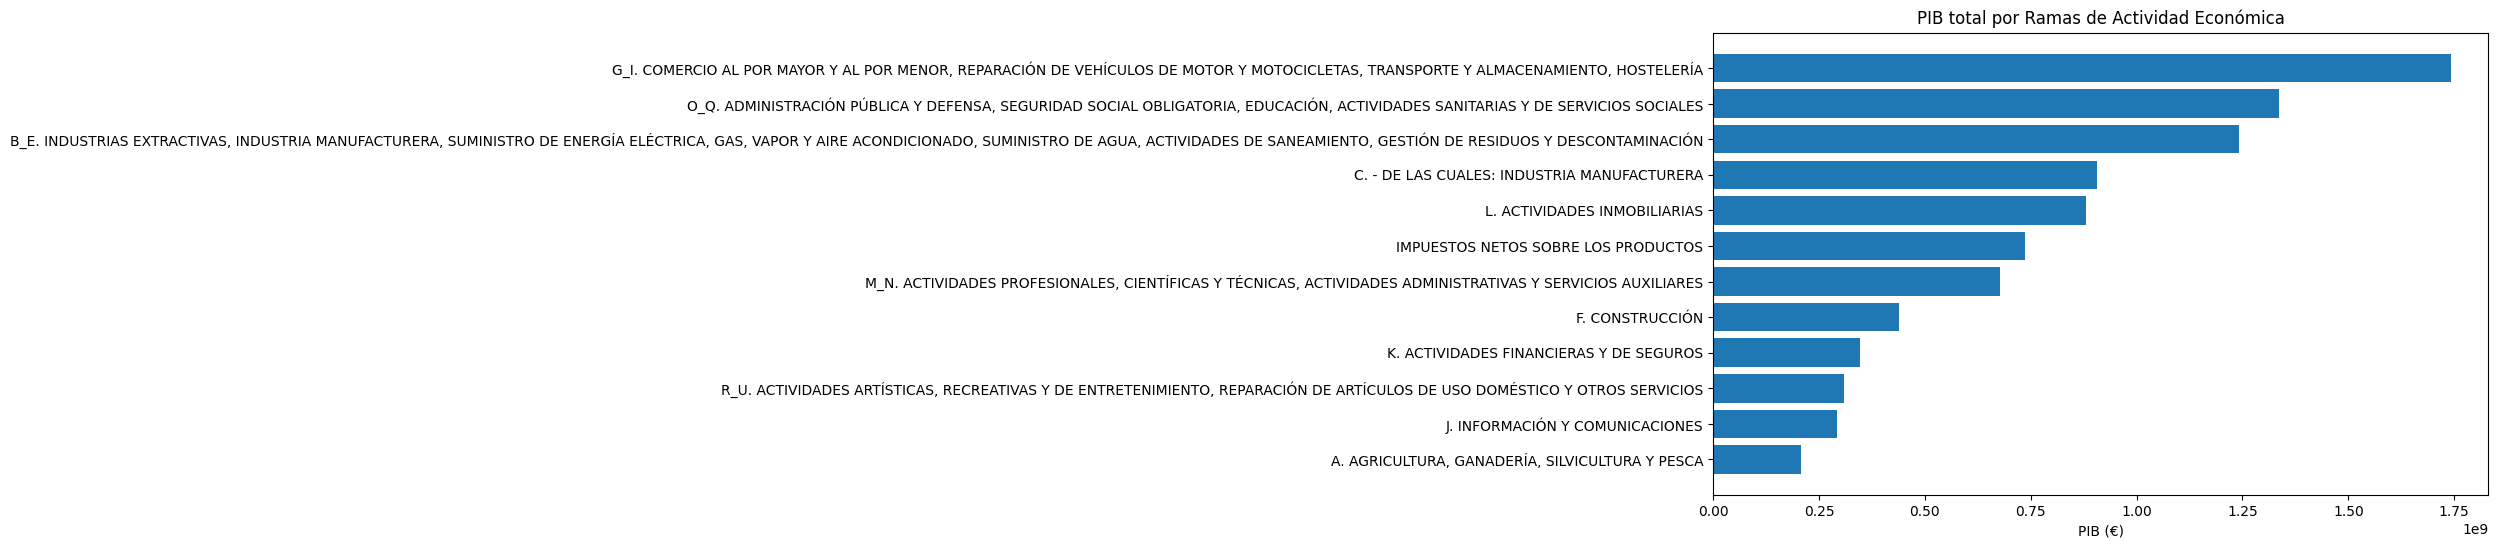

In [6]:
# visualization of the data
df_pib.columns = df_pib.columns.str.strip()
print(df_pib.columns)

# Remove rows with 'PRODUCTO INTERIOR BRUTO' or 'Valor añadido bruto' in 'Ramas de actividad'
df_pib = df_pib[~df_pib['Ramas de actividad'].str.contains('PRODUCTO INTERIOR BRUTO|Valor añadido bruto', case=False, na=False)]

# Format the 'PIB (€)' column to ensure it is numeric
df_pib['PIB (€)'] = pd.to_numeric(df_pib['PIB (€)'].astype(str).str.replace(',', '.'), errors='coerce')
df_merged['PIB (€)'] = df_merged['PIB por empresa actividad'] * df_merged['Nº Empresas']
df_merged['PIB por empresa (€)'] = df_merged['PIB (€)'] / df_merged['Nº Empresas']

# Group by 'Ramas de actividad' and sum the 'PIB (€)' column
df_pib_agg = df_pib.groupby('Ramas de actividad', as_index=False)['PIB (€)'].sum()

# Order the aggregated DataFrame by 'PIB (€)' in descending order
df_pib_agg = df_pib_agg.sort_values(by='PIB (€)', ascending=False)

print("PIB por actividad económica agregado:")
print(df_pib_agg)

# Plotting the aggregated PIB data
plt.figure(figsize=(10, 6))
plt.barh(df_pib_agg['Ramas de actividad'], df_pib_agg['PIB (€)'])
plt.xlabel('PIB (€)')
plt.title('PIB total por Ramas de Actividad Económica')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


BLOCK 6: EXPORT TO EXCEL

In [7]:
# Export final dataset to Excel
OUTPUT_FILE = 'Perfil_Empresarial_vs_PIB_pipeline.xlsx'
df_merged.to_excel(OUTPUT_FILE, index=False)

print(f"Final dataset exported: {OUTPUT_FILE}")

Final dataset exported: Perfil_Empresarial_vs_PIB_pipeline.xlsx
